# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

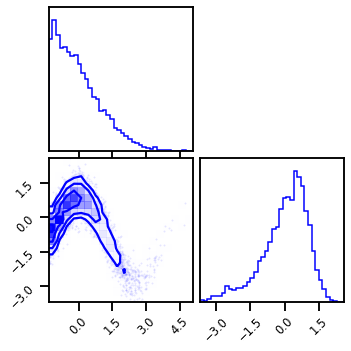

In [134]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
seed = 123
n_samples = 5_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [135]:
X = jnp.array(data, dtype=np.float32)

## Model

### Layer 1 - Mixture Gaussian CDF

In [181]:
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF

In [137]:
# spline parameters
range_min = -10.0
n_components = 10
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

In [182]:
init_mixcdf_f = InitMixtureGaussianCDF(
    n_components=n_components,
)

mcdf_bijector = init_mixcdf_f(key, n_features)

#### Forward Transformation

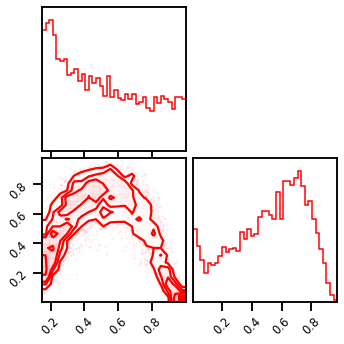

In [183]:
X_l1 = mcdf_bijector.forward(X)

# plot
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)

#### Inverse Transformation

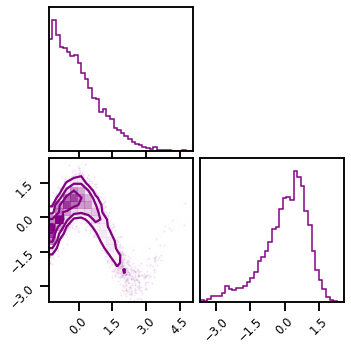

In [184]:
X_approx = mcdf_bijector.inverse(X_l1)

# plot
fig = corner.corner(X_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

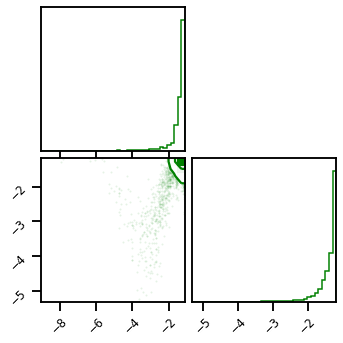

In [185]:
X_ldj = mcdf_bijector.forward_log_det_jacobian(X)

# plot
fig = corner.corner(X_ldj, color="green", hist_bin_factor=2)

### Layer II - Logit Transform

In [186]:
# Logit transform
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

logit_bijector = Inverse(Sigmoid())

In [187]:
# from rbig_jax.transforms.logit import InitLogit

In [188]:
# # layer parameters
# init_func = InitLogit()


# # initialize the bijector
# key, hh_rng = jax.random.split(key, 2)
# bijectors.append(Inverse(Sigmoid()))

# logit_bijector = init_func(hh_rng, n_features)
logit_bijector = Inverse(Sigmoid())

#### Forward Transformation

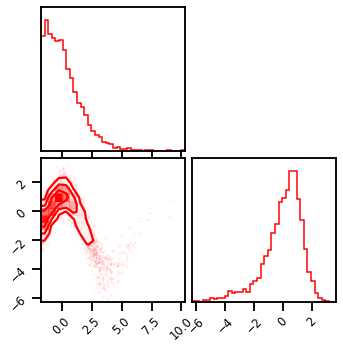

In [189]:
X_l2 = logit_bijector.forward(X_l1)

# plot
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

#### Inverse Transformation

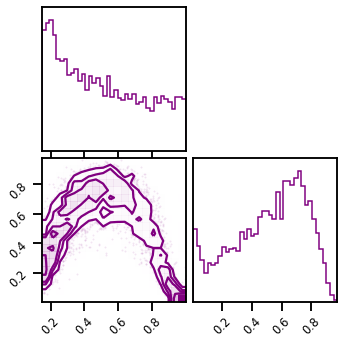

In [190]:
X_l1_approx = logit_bijector.inverse(X_l2)

# plot
fig = corner.corner(X_l1_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

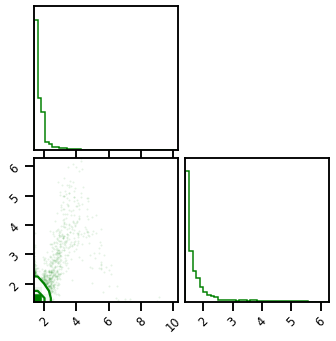

In [191]:
X_l2_ldj = logit_bijector.forward_log_det_jacobian(X_l1)


# plot
fig = corner.corner(X_l2_ldj, color="green", hist_bin_factor=2)

### Layer III - HouseHolder Reflections

In [192]:
from rbig_jax.transforms.parametric.householder import InitHouseHolder

# layer parameters
n_reflections = 2

init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

#### Forward Transformation

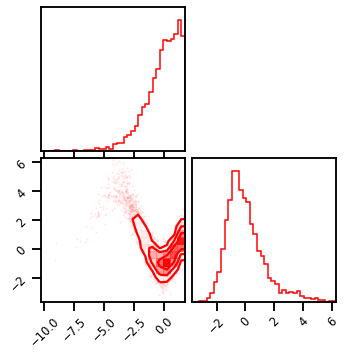

In [193]:
X_l3 = hh_bijector.forward(X_l2)

# plot
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)

#### Inverse Transformation

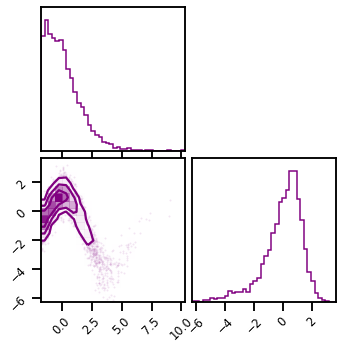

In [194]:
X_l2_approx = hh_bijector.inverse(X_l3)

# plot
fig = corner.corner(X_l2_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

In [195]:
X_l3_ldj = hh_bijector.forward_log_det_jacobian(X_l2)

chex.assert_equal(X_l3_ldj.min(), X_l3_ldj.max())

## Chaining Transformations

In [196]:
from rbig_jax.transforms.base import cascade_forward_and_log_det, cascade_inverse_and_log_det

#### Forward Transformation

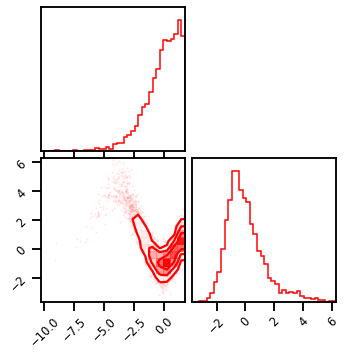

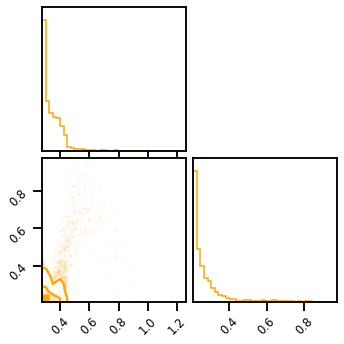

In [197]:
# initialize list of bijectors
bijectors = [
    mcdf_bijector,
    logit_bijector,
    hh_bijector
]

# cascade the transform
X_l2, X_l2_ldj = cascade_forward_and_log_det(bijectors, X)

# plot latent space
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l2_ldj, color="orange", hist_bin_factor=2)

#### Inverse Transformation

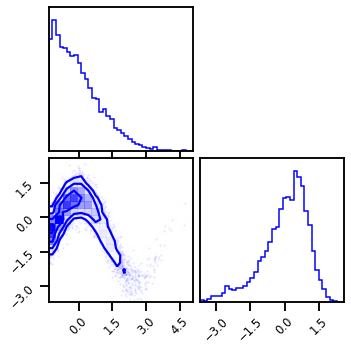

In [198]:

# cascade the transform
X_approx, _ = cascade_inverse_and_log_det(bijectors, X_l2)

# plot latent space
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

### Convenience Function

In [199]:
from typing import List, Iterable
from rbig_jax.transforms.base import BijectorChain

In [200]:
# initialize chain
chain_bijectors = BijectorChain(bijectors=bijectors)

In [201]:
X_l3.min(), X_l3.max(), X_l3.shape

(DeviceArray(-10.286362, dtype=float32),
 DeviceArray(6.2877326, dtype=float32),
 (5000, 2))

In [202]:
X_l3_ldj.min(), X_l3_ldj.max(), X_l3_ldj.shape

(DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32), (5000, 2))

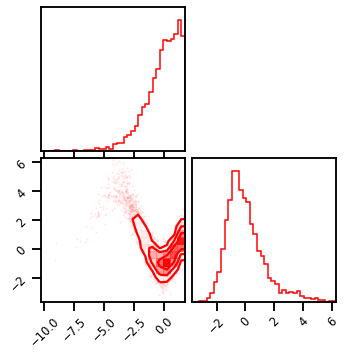

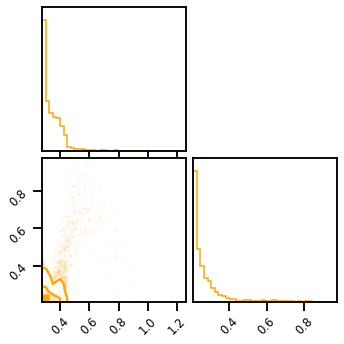

In [203]:
# cascade the transform
X_l3, X_l3_ldj = chain_bijectors.forward_and_log_det(X)

# plot latent space
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l3_ldj, color="orange", hist_bin_factor=2)

## Training

In [204]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 256
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

In [206]:
# spline parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

# init_mixcdf_f = InitMixtureLogisticCDF(
#     n_components=n_components,
# )
init_mixcdf_f = InitMixtureGaussianCDF(
    n_components=n_components,
)


mcdf_bijector = init_mixcdf_f(key, n_features)

# Logit transform
logit_bijector = Inverse(Sigmoid())

# Householder Transformation
n_reflections = 2
init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

# create chain
bijectors = [mcdf_bijector, logit_bijector, hh_bijector]
# bijectors = [mcdf_bijector, logit_bijector]

In [207]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# create base dist
base_dist = Normal(jnp.zeros((n_features,)),jnp.ones((n_features,)))

# create flow model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

### Optimizers

In [208]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


lr = 0.05
optimizer = optimizers.adam(step_size=lr)
jitted = True
epochs = 50



# train model
final_bijector, losses = train_model(gf_model, dl, epochs=epochs, optimizer=optimizer, lr=lr, jitted=jitted)

100%|██████████| 50/50 [00:08<00:00,  6.20it/s, loss=2.5892]


### Training Loop

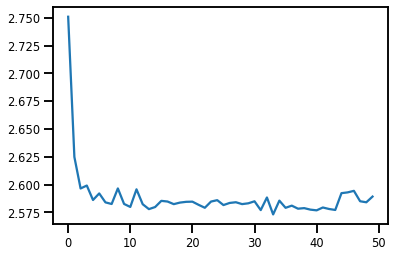

In [209]:
plt.plot(losses)

## Results

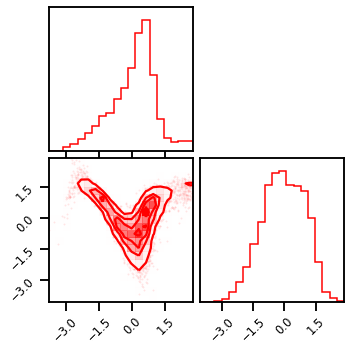

In [210]:
X_trans = final_bijector.forward(data)
# X_trans, _ = final_bijector.forward_and_log_det(data)

fig = corner.corner(X_trans, color="Red")

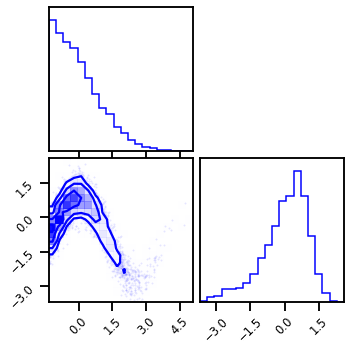

In [211]:
X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

## More Layers

In [221]:
# spline parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

# init_mixcdf_f = InitMixtureLogisticCDF(
#     n_components=n_components,
# )
init_mixcdf_f = InitMixtureGaussianCDF(
    n_components=n_components,
)

# Logit Transformation
logit_bijector = Inverse(Sigmoid())

# Householder Transformation
n_reflections = 2
init_hh_func = InitHouseHolder(n_reflections=n_reflections)

# create keys for all inits
n_layers = 5
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers)

for irng in layer_rngs:
    
    # create keys for all inits
    bijectors.append(init_mixcdf_f(irng, n_features))
    
    # create keys for all inits
#     bijectors.append(init_logit_func(irng, n_features))
    bijectors.append(logit_bijector)
    
    # create keys for all inits
    bijectors.append(init_hh_func(hh_rng, n_features))

# # create chain
# chain_bijectors = BijectorChain(bijectors=bijectors)

In [222]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# create base dist
base_dist = Normal(jnp.zeros((n_features,)),jnp.ones((n_features,)))

# create flow model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

#### Training

In [223]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 0.005
optimizer = optimizers.adam(step_size=0.05)
jitted = True
# epochs = 150
epochs = 100

# train model
final_bijector, losses = train_model(gf_model, dl, epochs=epochs, optimizer=optimizer, lr=lr, jitted=jitted)

100%|██████████| 100/100 [00:34<00:00,  2.92it/s, loss=nan]


### Results

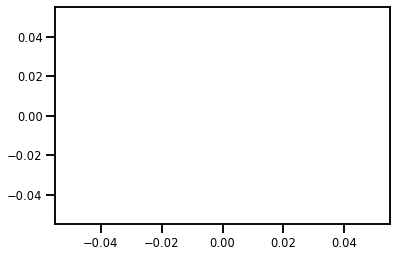

In [215]:
plt.plot(losses)

#### Latent Space

ValueError: supplied range of [nan, nan] is not finite

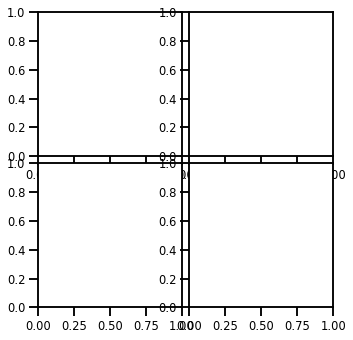

In [216]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

In [217]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

ValueError: It looks like the parameter(s) in column(s) 0, 1 have no dynamic range. Please provide a `range` argument.

### Log Probability

In [218]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X, 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

CPU times: user 9.36 s, sys: 3.84 s, total: 13.2 s
Wall time: 2.84 s


#### Plot: Original Density

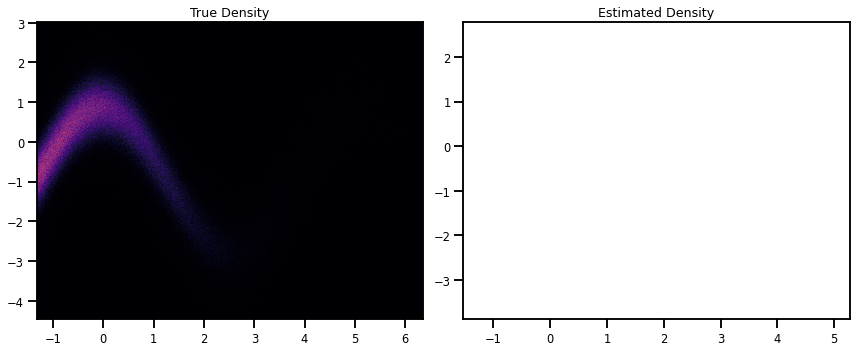

In [219]:
# Original Density
n_samples = 1_000_000
n_features = 2
X_plot = get_classic(n_samples, seed=123)
X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)



cmap = cm.magma # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
h = ax[0].hist2d(X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0., vmax=1.)
ax[0].set_title("True Density")
ax[0].set(xlim=[X_plot[:, 0].min(), X_plot[:,0].max()], ylim=[X_plot[:,1].min(), X_plot[:,1].max()])

h1 = ax[1].scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0)
ax[1].set(xlim=[xyinput[:, 0].min(), xyinput[:,0].max()], ylim=[xyinput[:,1].min(), xyinput[:,1].max()])
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [220]:
X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))
X_g_samples.shape

(10000, 2)

In [176]:
%%time
# generate samples in the latent domain
n_gen_samples = 10_000

X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))

X_samples = final_bijector.inverse(X_g_samples)

# X_samples = np.array(gf_model.inverse(X_g_samples.block_until_ready()))

# # inverse transformation
# f = jax.jit(gf_model.inverse)
# X_samples = np.array(f(X_g_samples))

# # This way works too! But slower
# # generate samples in the latent domain
# n_gen_samples = 10_000

# # # inverse transformation
# X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 1min 13s, sys: 1.99 s, total: 1min 15s
Wall time: 18.9 s


In [177]:
from scipy.stats import zscore

In [178]:
z = zscore(X_samples)
t.shape

(10000, 2)

In [179]:
np.abs(zscore(X_samples)).shape

(10000, 2)

In [180]:
X_samples_ = X_samples[np.abs(zscore(X_samples))<=3]
X_samples_.shape

(19826,)

In [124]:
X_samples.min(), X_samples.max()

(DeviceArray(-499.5, dtype=float32), DeviceArray(500.5, dtype=float32))

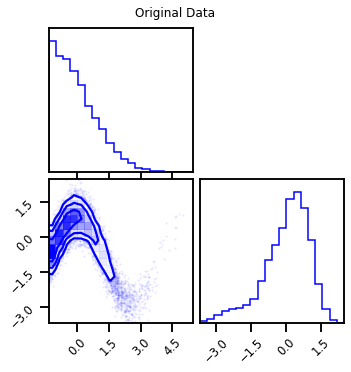

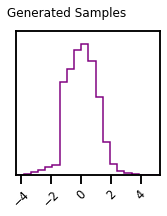

In [129]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples_, color="purple")
fig2.suptitle("Generated Samples")
plt.show()